In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization
from skimage.filters import threshold_otsu
import warnings

warnings.filterwarnings('ignore')

In [19]:

DATASET_PATH = r"./dataset/"
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
EPOCHS = 30
BATCH_SIZE = 32
SEED = 42
dataset_folders = []
total = 0
print(f"There are {len(os.listdir(DATASET_PATH))} folder in dataset.")
for path in sorted(os.listdir(DATASET_PATH)):
    print(f"\t-There are {len(os.listdir(DATASET_PATH + path))} images in {path} folder.")
    total += len(os.listdir(DATASET_PATH + path))
    folder_path = DATASET_PATH + path
    dataset_folders.append(folder_path)

df = pd.DataFrame(0,
                  columns=['paths',
                           'class-label'],
                  index=range(total))
i = 0
for p, path in enumerate(dataset_folders):
    for sub_path in sorted(os.listdir(path)):
        df.iloc[i, 0] = path + "/" + sub_path
        df.iloc[i, 1] = p
        i += 1
#To see content of data frame
print(df.sample(frac=1, random_state=42).head(10))

There are 4 folder in dataset.
	-There are 300 images in 1_normal folder.
	-There are 100 images in 2_cataract folder.
	-There are 101 images in 2_glaucoma folder.
	-There are 100 images in 3_retina_disease folder.
                                         paths  class-label
110              ./dataset/1_normal/NL_111.png            0
419      ./dataset/2_glaucoma/Glaucoma_020.png            2
565  ./dataset/3_retina_disease/Retina_065.png            3
77               ./dataset/1_normal/NL_078.png            0
181              ./dataset/1_normal/NL_182.png            0
284              ./dataset/1_normal/NL_285.png            0
10               ./dataset/1_normal/NL_011.png            0
469      ./dataset/2_glaucoma/Glaucoma_070.png            2
78               ./dataset/1_normal/NL_079.png            0
349      ./dataset/2_cataract/cataract_050.png            1


In [20]:
#normalizes the histogram of images
def normalize_histograms(img):
    image_copy = img.copy()
    for i in range(3):
        imi = img[:, :, i]
        minval = np.min(imi)
        maxval = np.max(imi)
        imrange = maxval - minval
        # imi-minval will turn the color range between 0-imrange, and the scaling will stretch the range between 0-255
        image_copy[:, :, i] = (255 / (imrange + 0.0001) * (imi - minval))
    return image_copy


#Cropping image to avoid from unuseful black areas
def deleteBlackAreas(filename):
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
    img = cv2.imread(filename)  #read image from file
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to grayscale
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)  # turn it into a binary image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # find contours
    if len(contours) != 0:
        #find the biggest area
        cnt = max(contours, key=cv2.contourArea)

        #find the bounding rect
        x, y, w, h = cv2.boundingRect(cnt)

        crop = img[y:y + h, x:x + w]  # crop image
        crop1 = cv2.cvtColor(cv2.resize(crop, image_size, interpolation=cv2.INTER_AREA),
                             cv2.COLOR_BGR2RGB)  # resize to image_size and change color space from BGR to RGB for matplotlib
        return crop1
    else:
        return cv2.resize(img, image_size, interpolation=cv2.INTER_AREA)

def otsu_threshold(imgp):
    imggray = cv2.cvtColor(imgp, cv2.COLOR_BGR2GRAY)
    #imgcon = (img1/256).astype('uint8')
    ret, img8b = cv2.threshold(imggray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return img8b

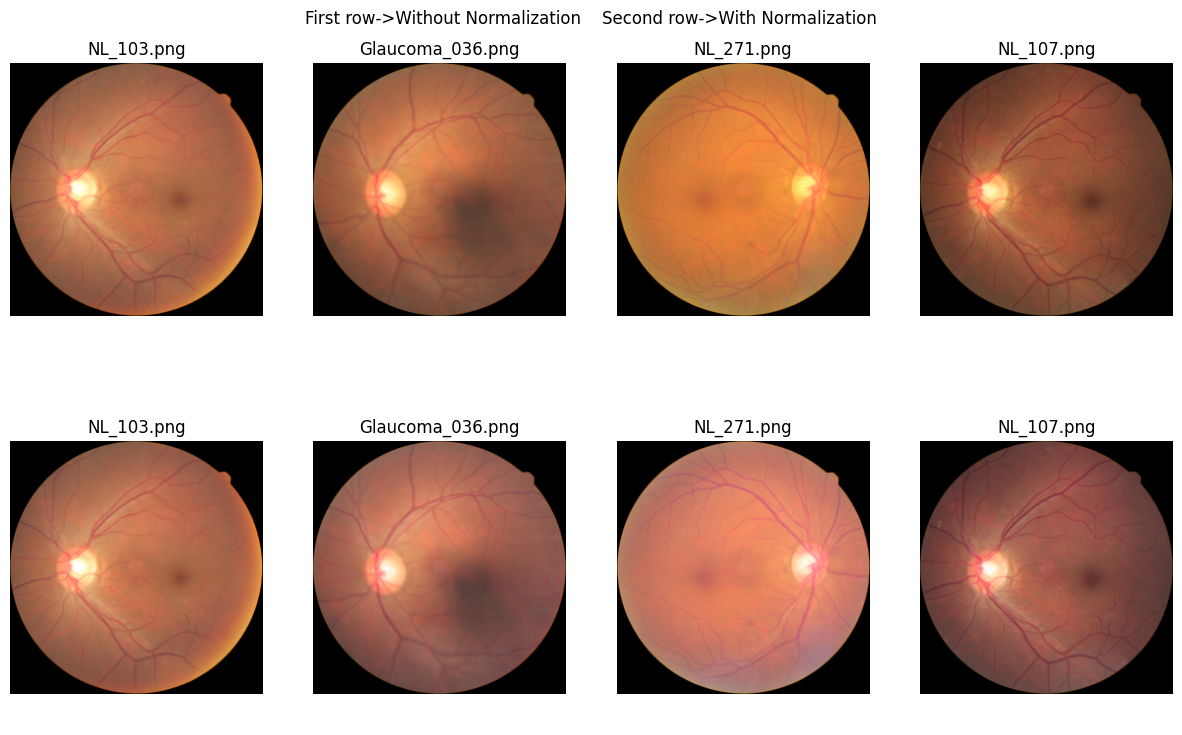

In [21]:
#Display Random 4 image to see what we have up to now
np.random.seed(SEED)
randoms = np.random.randint(0, len(df), 4)
fig = plt.figure(figsize=(15, 9))
plt.title("First row->Without Normalization    Second row->With Normalization")
plt.axis('off')
plt.grid(False)
for i in range(4):
    fig.add_subplot(2, 4, i + 1)
    img = deleteBlackAreas(df.iloc[randoms[i]]["paths"])
    plt.axis('off')
    plt.title(df.iloc[randoms[i]]["paths"].split("/")[3])
    plt.imshow(img)

    fig.add_subplot(2, 4, i + 5)
    img2 = normalize_histograms(img)
    plt.axis('off')
    plt.title(df.iloc[randoms[i]]["paths"].split("/")[3])
    plt.imshow(img2)



In [22]:
def create_dataset(df, mode=0):
    # Creating dataset
    images = []
    labels = []
    df = df.sample(frac=1, random_state=SEED)
    for i in range(len(df)):
        filename = df.iloc[i]["paths"]
        img = deleteBlackAreas(filename)
        if mode == 1:
            img = normalize_histograms(img)
        elif mode == 2:
            img = otsu_threshold(img) #thing here
        label = df.iloc[i]["class-label"]
        images.append(img)
        labels.append(label)
    return split_dataset(images, labels)


def split_dataset(images, labels):
    # set aside 20% of train and test data for evaluation
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=SEED)
    # Use the same function above for the validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    print("X_train shape: {}".format(X_train.shape))
    print("X_test shape: {}".format(X_test.shape))
    print("y_train shape: {}".format(y_train.reshape(-1, 1).shape))
    print("y_test shape: {}".format(y_test.reshape(-1, 1).shape))
    print("X_val shape: {}".format(X_val.shape))
    print("y_val shape: {}".format(y_val.reshape(-1, 1).shape))
    return [X_train, X_test, y_train, y_test, X_val, y_val]

In [23]:
[X_train, X_test, y_train, y_test, X_val, y_val] = create_dataset(df)

X_train shape: (360, 256, 256, 3)
X_test shape: (121, 256, 256, 3)
y_train shape: (360, 1)
y_test shape: (121, 1)
X_val shape: (120, 256, 256, 3)
y_val shape: (120, 1)


[181, 54, 61, 64]
[59, 25, 21, 15]
[60, 21, 19, 21]


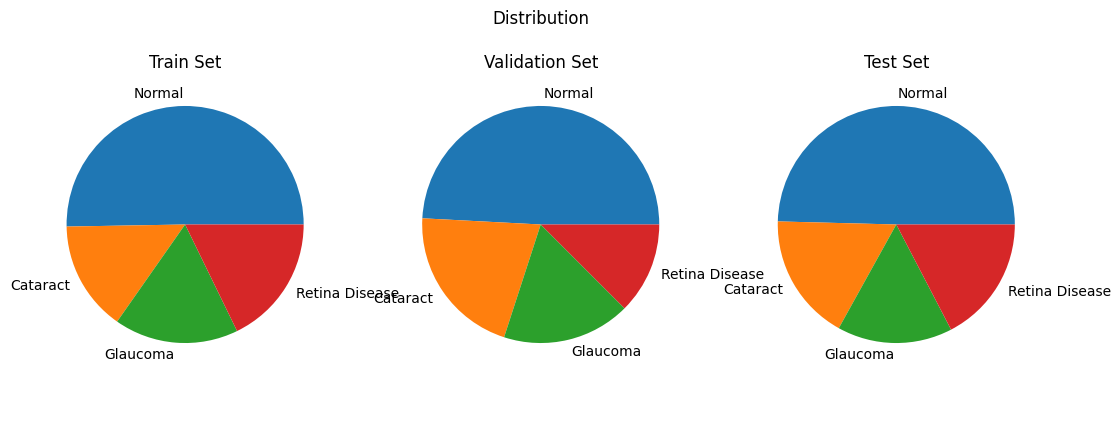

In [24]:
def plot_pie_sets(arrays):
    titles = ["Train Set", "Validation Set", "Test Set"]
    labels = ["Normal", "Cataract", "Glaucoma", "Retina Disease"]
    fig = plt.figure(figsize=(13, 5))
    plt.title("Distribution")
    plt.axis('off')
    plt.grid(False)
    for i in range(3):
        fig.add_subplot(1, 3, i + 1)
        arr = []
        for j in range(4):
            arr.append((arrays[i] == j).sum())
        labels = ["Normal", "Cataract", "Glaucoma", "Retina Disease"]
        print(arr)
        plt.title(titles[i])
        plt.pie(arr, labels=labels)


plot_pie_sets([y_train, y_val, y_test])

In [25]:


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=[256, 256, 3]),
    MaxPooling2D(),
    Conv2D(64, (2, 2), padding="same", activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (2, 2), padding="same", activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])



In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      8256      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)        16448     
                                                                 
 flatten_3 (Flatten)         (None, 262144)           

In [27]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_val = np.asarray(X_val).astype(np.float32)
y_val = np.asarray(y_val).astype(np.float32)
history_vanilla = model.fit(X_train, y_train.flatten(), batch_size=BATCH_SIZE, epochs=EPOCHS,
                            validation_data=(X_val, y_val.flatten()))
model.evaluate(X_test, y_test.flatten(), verbose=2)

Epoch 1/30
12/12 [==============================] - 26s 2s/step - loss: 501.8870 - accuracy: 0.3333 - val_loss: 5.5039 - val_accuracy: 0.1500
Epoch 2/30
12/12 [==============================] - 21s 2s/step - loss: 1.8423 - accuracy: 0.4472 - val_loss: 1.4414 - val_accuracy: 0.3250
Epoch 3/30
12/12 [==============================] - 21s 2s/step - loss: 1.2451 - accuracy: 0.4861 - val_loss: 1.1963 - val_accuracy: 0.5000
Epoch 4/30
12/12 [==============================] - 22s 2s/step - loss: 1.1848 - accuracy: 0.5194 - val_loss: 1.2786 - val_accuracy: 0.4917
Epoch 5/30
12/12 [==============================] - 21s 2s/step - loss: 1.1515 - accuracy: 0.5083 - val_loss: 1.1373 - val_accuracy: 0.5417
Epoch 6/30
12/12 [==============================] - 21s 2s/step - loss: 1.1184 - accuracy: 0.5250 - val_loss: 1.1605 - val_accuracy: 0.4917
Epoch 7/30
12/12 [==============================] - 21s 2s/step - loss: 1.1051 - accuracy: 0.5222 - val_loss: 1.1282 - val_accuracy: 0.5333
Epoch 8/30
12/12 [

[2.9154891967773438, 0.4793388545513153]

In [28]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

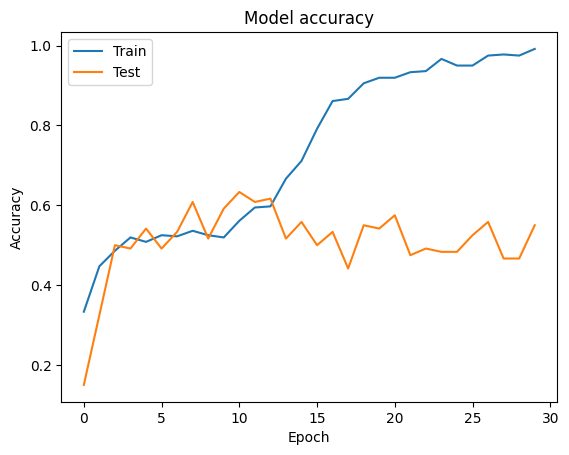

In [29]:
plot_history(history_vanilla)

# NORMALIZED

In [31]:
#images, labels = create_dataset(df, 1)

X_train shape: (360, 256, 256, 3)
X_test shape: (121, 256, 256, 3)
y_train shape: (360, 1)
y_test shape: (121, 1)
X_val shape: (120, 256, 256, 3)
y_val shape: (120, 1)


ValueError: too many values to unpack (expected 2)

In [32]:
[X_train, X_test, y_train, y_test, X_val, y_val] = create_dataset(df, 1)

X_train shape: (360, 256, 256, 3)
X_test shape: (121, 256, 256, 3)
y_train shape: (360, 1)
y_test shape: (121, 1)
X_val shape: (120, 256, 256, 3)
y_val shape: (120, 1)


In [33]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
history_normalized = model.fit(X_train, y_train.flatten(), batch_size=BATCH_SIZE, epochs=EPOCHS,
                               validation_data=(X_val, y_val.flatten()))
model.evaluate(X_test, y_test.flatten(), verbose=2)

Epoch 1/30
12/12 [==============================] - 22s 2s/step - loss: 1.2078 - accuracy: 0.7778 - val_loss: 1.6285 - val_accuracy: 0.4083
Epoch 2/30
12/12 [==============================] - 23s 2s/step - loss: 0.3661 - accuracy: 0.8833 - val_loss: 1.4686 - val_accuracy: 0.4917
Epoch 3/30
12/12 [==============================] - 21s 2s/step - loss: 0.3140 - accuracy: 0.8694 - val_loss: 1.4361 - val_accuracy: 0.4833
Epoch 4/30
12/12 [==============================] - 21s 2s/step - loss: 0.2312 - accuracy: 0.9167 - val_loss: 1.9978 - val_accuracy: 0.5167
Epoch 5/30
12/12 [==============================] - 21s 2s/step - loss: 0.1981 - accuracy: 0.9222 - val_loss: 1.7751 - val_accuracy: 0.4583
Epoch 6/30
12/12 [==============================] - 21s 2s/step - loss: 0.1574 - accuracy: 0.9500 - val_loss: 1.7025 - val_accuracy: 0.5167
Epoch 7/30
12/12 [==============================] - 21s 2s/step - loss: 0.1077 - accuracy: 0.9750 - val_loss: 1.8834 - val_accuracy: 0.5167
Epoch 8/30
12/12 [==

[3.20386004447937, 0.40495866537094116]

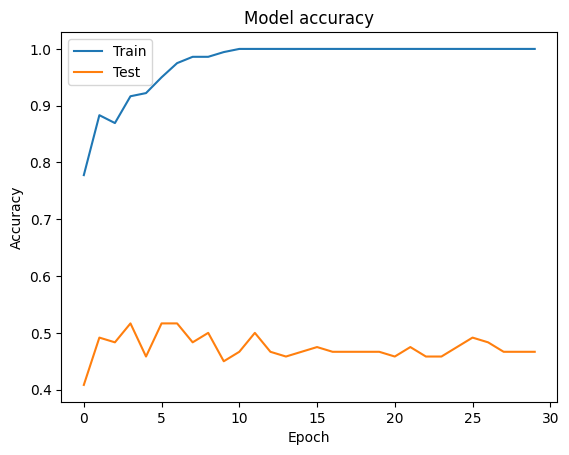

In [34]:
plot_history(history_normalized)

# DATA SAYISI ARTIRMA

# HANGİ PREPROCES İŞLEMLERİ YAPILACAK KARARI

Otsu threshold

X_train shape: (360, 256, 256)
X_test shape: (121, 256, 256)
y_train shape: (360, 1)
y_test shape: (121, 1)
X_val shape: (120, 256, 256)
y_val shape: (120, 1)
Epoch 1/30
12/12 [==============================] - 21s 2s/step - loss: 1091.5416 - accuracy: 0.2833 - val_loss: 91.6851 - val_accuracy: 0.2083
Epoch 2/30
12/12 [==============================] - 20s 2s/step - loss: 61.6711 - accuracy: 0.2750 - val_loss: 3.8733 - val_accuracy: 0.4750
Epoch 3/30
12/12 [==============================] - 20s 2s/step - loss: 2.0756 - accuracy: 0.4000 - val_loss: 1.6367 - val_accuracy: 0.1750
Epoch 4/30
12/12 [==============================] - 20s 2s/step - loss: 1.2019 - accuracy: 0.4833 - val_loss: 1.2457 - val_accuracy: 0.4750
Epoch 5/30
12/12 [==============================] - 19s 2s/step - loss: 1.1659 - accuracy: 0.5361 - val_loss: 1.2547 - val_accuracy: 0.4750
Epoch 6/30
12/12 [==============================] - 20s 2s/step - loss: 1.1259 - accuracy: 0.5444 - val_loss: 1.2574 - val_accuracy: 0.4

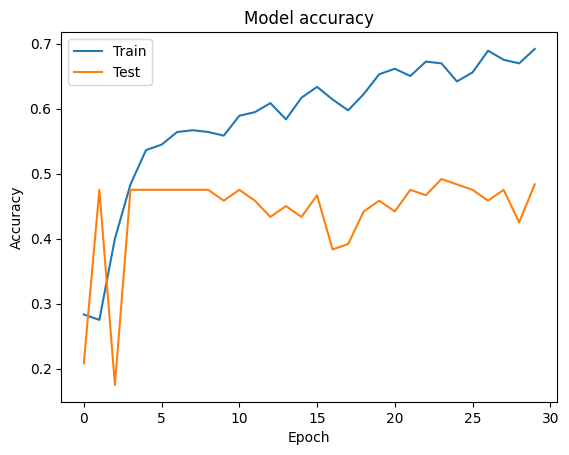

In [37]:
#images, labels = create_dataset(df, 2)
modelotsu = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=[256, 256, 1]),
    MaxPooling2D(),
    Conv2D(64, (2, 2), padding="same", activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (2, 2), padding="same", activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

[X_train, X_test, y_train, y_test, X_val, y_val] = create_dataset(df, 2)

modelotsu.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
history_otsu = modelotsu.fit(X_train, y_train.flatten(), batch_size=BATCH_SIZE, epochs=EPOCHS,
                               validation_data=(X_val, y_val.flatten()))
modelotsu.evaluate(X_test, y_test.flatten(), verbose=2)
plot_history(history_otsu)